In [2]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from helper_functions import Percentile, Normalizer
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Names of properties related to coupling coefficients and tribe sizes
spec_comm_coupling = ['Community coupling', 'Mean tribe community coupling']
spec_size_related = ['Mean size']

fig_6d_plot_params = {"marker": '.', "ms": 5,
                      "ls": 'None'}
fig_6d_fit_params = {"ls": '--', "color": 'black'}

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 6")

In [3]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

# Values of the topological parameters for all neuron samples
tribe_struc_params = data.TopoData(tribe_struc_params_fn)

# The identifiers of neurons in all neuron samples.
# Used to determine sample sizes and mean values of topol. parameters.
tribe_gids = data.TopoData(tribe_gids_fn)['gids']

# The "database" with topological and functional parameters for all neurons in the model
db = pandas.read_pickle(db_fn)

# Finally, the classification accuracies for all neuron samples
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']

In [4]:
"""
Some analysis of the data
"""
# The mean accuracy of a sample over the 5-times cross-validation
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)

# The sizes of all neuron samples
# tribe_size = tribe_gids.map(len)
# Add the size of the samples to the data structure holding the other topological and functional parameters
# tribe_struc_params.data["Tribe size"] = tribe_size

# For each sample look up the contained neurons, calculate the sizes of their associated tribes and take the mean.
# I.e. the mean size of tribes whose chief is contained in the sample. This gives a measure of the average
# connectedness of the neuron sample.
all_lengths = db["tribe"].apply(len) # Look up tribe size for _all_ tribes in the db
tribe_struc_params.data["Mean size"] =\
tribe_gids.map(lambda x: numpy.mean(all_lengths.loc[x])) # And calculate mean size of contained neurons

In [5]:
from pandas_helper import assemble_result_dataframe, sanitize_param_name
from helper_functions import analyze_linear_fit
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

"""
We do some more analysis here. Some of the functions we use require data in the form a pandas.Dataframes.
We have a helper function that assembles the data accordingly. Let's build those dataframes!
"""

# We found that this analysis has to be performed separately for tribes whose chief is in L1-5 and L6.
# So we list here all morphological tribes in L1-5 and L6 separately
mtypes_l1_l5 = ['L1_DAC', 'L1_DLAC', 'L1_HAC', 'L1_NGC-DA', 'L1_NGC-SA', 'L1_SLAC', 'L23_BP', 'L23_BTC',
                   'L23_ChC', 'L23_DBC', 'L23_LBC', 'L23_MC', 'L23_NBC', 'L23_NGC', 'L23_PC', 'L23_SBC',
                   'L4_BP', 'L4_BTC', 'L4_ChC', 'L4_DBC', 'L4_LBC', 'L4_MC', 'L4_NBC', 'L4_NGC', 'L4_PC',
                   'L4_SBC', 'L4_SP', 'L4_SS', 'L5_BP', 'L5_BTC', 'L5_ChC', 'L5_DBC', 'L5_LBC', 'L5_MC',
                   'L5_NBC', 'L5_NGC', 'L5_SBC', 'L5_STPC', 'L5_TTPC1', 'L5_TTPC2', 'L5_UTPC']
mtypes_l6 = ['L6_BP', 'L6_BPC', 'L6_BTC', 'L6_ChC', 'L6_DBC', 'L6_IPC', 'L6_LBC', 'L6_MC', 'L6_NBC',
             'L6_NGC', 'L6_SBC', 'L6_TPC_L1', 'L6_TPC_L4', 'L6_UTPC']

# Tribe-size related data for the randomly picked tribes
# We need that to generate the "mean size"-based predictor
dframe_random_tribes =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, # Accuracy data
                          tribe_struc_params, # Structural and coupling-related data
                          sampling="M-type", # Which type of sample to look up
                          parameters_to_add=spec_size_related, # Which parameters to add
                          normalize=[])

# To analyze how tribe size determines the coupling coefficient and the cc in turn determines accuray we
# build dataframes with results for the random tribe samples. As mentioned above, we do that separately for L1-5
# and L6.
# Accuracies, coupling-related and tribe-size-related data for randomly picked tribes in L1-5
dframe_tribes_coupl_l1l5 =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="M-type",
                          labels_to_iterate=mtypes_l1_l5, # Which specific samples (mtypes) to look up
                          parameters_to_add=spec_comm_coupling + spec_size_related,
                          normalize=[])
# Accuracies, coupling-related and tribe-size-related data for randomly picked tribes in L6
dframe_tribes_coupl_l6 =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="M-type",
                          labels_to_iterate=mtypes_l6,
                          parameters_to_add=spec_comm_coupling + spec_size_related,
                          normalize=[])

# Accuracies, tribes-size and coupling-related data for volumetric samples. To study how the findings generalize
# to volumetric samples
dframe_vol_coupl =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="Radius",
                          parameters_to_add=spec_comm_coupling + spec_size_related,
                          normalize=spec_comm_coupling)


# To provide an example of what we got from this
display(dframe_vol_coupl)

"""
Now analyze. We fit a linear fit of mean tribe size against accuracy using the random samples, as we did
in the notebook for Figure 4. That is, we use the same fit as before!
"""
model_size = ols("Accuracy ~ Mean_size", data=dframe_random_tribes).fit()

"""
Add the residuals to the dataframes. For the dataframe we fit the model on we can directly look it up.
For the volumetric data, we instead subtract the prediction
"""
dframe_vol_coupl["Accuracy_residual"] = dframe_vol_coupl["Accuracy"] -\
                                        model_size.predict(dframe_vol_coupl)

residual_data_vol = analyze_linear_fit(dframe_vol_coupl, spec_comm_coupling,
                                       column_y="Accuracy_residual")

,specifier,Accuracy,Community_coupling,Mean_tribe_community_coupling,Mean_size
0,125 um,0.739340,1.664016,1.139471,836.361667
1,125 um,0.603356,1.104324,0.231514,794.321667
2,125 um,0.470894,-0.240993,-0.108917,797.161667
3,125 um,0.716073,1.358395,2.301916,613.893333
4,125 um,0.475528,-1.191419,-0.594644,826.391667
...,...,...,...,...,...
120,325 um,0.849926,-0.560836,0.063302,682.660000
121,325 um,0.832684,-0.167660,0.424885,671.518333
122,325 um,0.813589,-0.096791,-0.967179,639.623333
123,325 um,0.809603,-0.148353,0.085445,659.593333


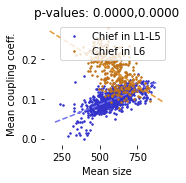

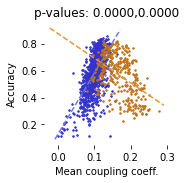

In [6]:
"""
Figure panels: Coupling coefficients against mean tribe size and accuracies for the "random" samples; 
separately for random samples where the chief is in L1-L5 and where the chief is in L6
"""
from matplotlib import pyplot as plt

def plot_function(fit_plt_x, fit_plt_y, xlabel, ylabel):
    ax = plt.figure(figsize=(2.25, 2.25)).gca()
    ax.plot(dframe_tribes_coupl_l1l5[fit_plt_x],
            dframe_tribes_coupl_l1l5[fit_plt_y], '.', ms=3, color=[0.2, 0.2, 0.8],
            label="Chief in L1-L5")
    model = ols("{0} ~ {1}".format(fit_plt_y, fit_plt_x), data=dframe_tribes_coupl_l1l5).fit()
    ax.plot(ax.get_xlim(), model.params["Intercept"] +
            model.params[fit_plt_x] * numpy.array(ax.get_xlim()),
           ls='--', color=[0.45, 0.45, 0.95])

    ax.plot(dframe_tribes_coupl_l6[fit_plt_x],
            dframe_tribes_coupl_l6[fit_plt_y], '.', ms=3, color=[0.75, 0.45, 0.1],
            label="Chief in L6")
    model_l6 = ols("{0} ~ {1}".format(fit_plt_y, fit_plt_x), data=dframe_tribes_coupl_l6).fit()
    ax.plot(ax.get_xlim(), model_l6.params["Intercept"] +
            model_l6.params[fit_plt_x] * numpy.array(ax.get_xlim()),
           ls='--', color=[0.9, 0.6, 0.2])

    ax.set_title("p-values: {0:5.4f},{1:5.4f}".format(model.pvalues[fit_plt_x],
                                           model_l6.pvalues[fit_plt_x]))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.box(False)

plot_function("Mean_size", "Mean_tribe_community_coupling", 
              "Mean size", "Mean coupling coeff.")
plt.legend()
F.save(plt.gcf(), fn="Panel-B")
plot_function("Mean_tribe_community_coupling", "Accuracy", 
              "Mean coupling coeff.", "Accuracy")
F.save(plt.gcf(), fn="Panel-C")


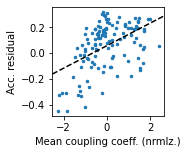

/home/reimann/venvs/topological_sampling/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


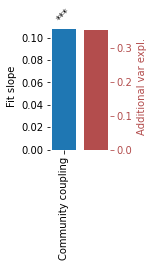

In [7]:
from plot_helpers import plot_linear_fit_results


fig = plt.figure(figsize=(2., 2.))
ax = fig.gca()

"""
Figure panel: Mean coupling coeff. in volumetric samples against their accuracy residual
"""
col = "Community coupling"
col_san = sanitize_param_name(col)
model = ols("Accuracy_residual ~ {0}".format(col_san), data=dframe_vol_coupl).fit()

ax.plot(dframe_vol_coupl[col_san],
        dframe_vol_coupl["Accuracy_residual"], **fig_6d_plot_params)
xx = ax.get_xlim(); ax.set_xlim(xx)
    
ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_6d_fit_params)
ax.set_xlabel("Mean coupling coeff. (nrmlz.)")
ax.set_ylabel("Acc. residual")

F.save(fig, fn="Panel-D")

plot_linear_fit_results(residual_data_vol, plot_params=["Community coupling"],
                        bar_col="#1f77b3", var_col=[0.7, 0.3, 0.3])
plt.gcf().axes[1].set_ylim([0, 0.375])
F.save(plt.gcf(), fn="Panel-E")

